==============================================================================================
# Practicum 6 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_2_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 23th, 23:00 h**

**Deadline (Group B): December 24th, 23:00 h**

==============================================================================================
## Dimensionality reduction and face detection
==============================================================================================

**Problem to solve**: Define a space of image feature that allows to represent objects based on their appearance or a set of local features in the image.

Documentation [Face recognition skimage](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

==============================================================================================


Today's exercices will practise the following:

1. Define an appropiate representation (descriptors objects):
    - Normally, reduce size of the data preserving the invariance and removing redundant dimensions.


2. Train a classifier from a set of examples with their descriptors.


3. Recognize a new face example using the learned model.

## Imports

In [1]:
from time import time

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

# Wrapper function to easily use subplot    
import math
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(18,8)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return



## Principal Component Analysis (PCA)

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


### 1. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**1.1** Load the dataset.

Obtain only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [2]:
# Load the dataset
from sklearn.datasets import fetch_lfw_people 

#Load the dataser with 100 images per category and resize them at 50%
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)


In [3]:
n_samples, h, w = lfw_people.images.shape #The shape is of the form (nth image, rows, cols)
print("Number of images:", n_samples)
print("Image shape (w,h):", w, h)
labels = lfw_people.target_names 
print("Labels:", labels)

Number of images: 1140
Image shape (w,h): 47 62
Labels: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


**1.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

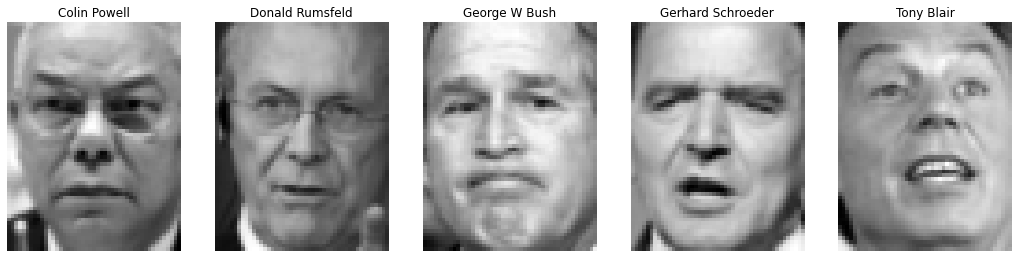

In [4]:
faces = []
names = []

for i in range(len(lfw_people.target_names)): #Iterate through each class
    for j in range(len(lfw_people.target)): # Iterate throught all the faces
        if lfw_people.target[j] == i: #Get the first face of the current class
            faces.append(lfw_people.images[j]) #Save the image in faces
            names.append(lfw_people.target_names[i]) #Save the name in names
            break; #If we find the face we are looking for, stop the inner loop and go to next class

#Print the found images
print_images(faces, names, colormap='gray')
            

**1.3** Divide the dataset into train and test set (0.7/0.3). 

**Hint:** use the train_test_split function.

In [5]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split 

#train_test_split. When we set test_size, train_size is automatically set. We also set a fixed seed in order for the 
# partition to be the same for each execution
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, test_size=0.3, random_state=6542)

### 2. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.


**2.1** Create a PCA object, using the training set and a 150 components

In [6]:
# Principal component analysis
from sklearn.decomposition import PCA

#Declare a PCA object with 150 components
classifier = PCA(n_components=150)

#Fit the model (find the 150 components given the images in X_train)
classifier.fit(X_train)


PCA(n_components=150)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

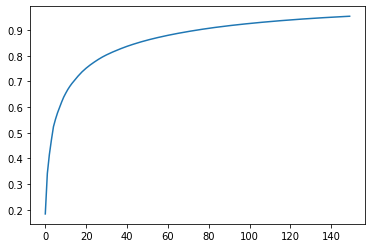

In [7]:
plt.plot(classifier.explained_variance_ratio_.cumsum())

What is the variable *pca*?

# Answer
PCA is an object used to operate "principal component analysis". We construct it with the paremeter "n_components" wich is the number of dimensions of the resulting space, after reduction. Then we will give it some data to train, and it will find the most important "features" (represented as dimensions or axis) and give us a base in this new low dimension space. It also contains the tools to evaluate and reduce new data and to test it with known data. 


**2.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

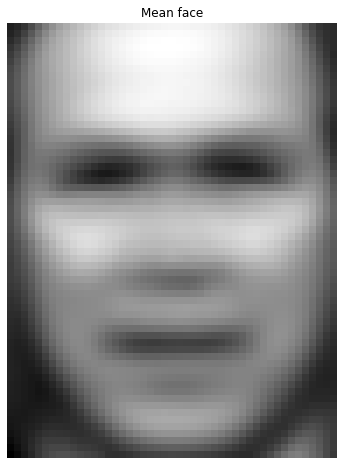

In [8]:
# Your solution here
mean_face = classifier.mean_ # Get the mean face (an array of 63*47=2914 pixels)
mean_face = np.reshape(mean_face, (62,47)) #resize it to the original image size
print_images([mean_face], ["Mean face"], colormap='gray') 

**2.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance.

Visualize 30 principal eigenfaces

<img src="notebook_images/eigenfaces.png" width=500, height=500>

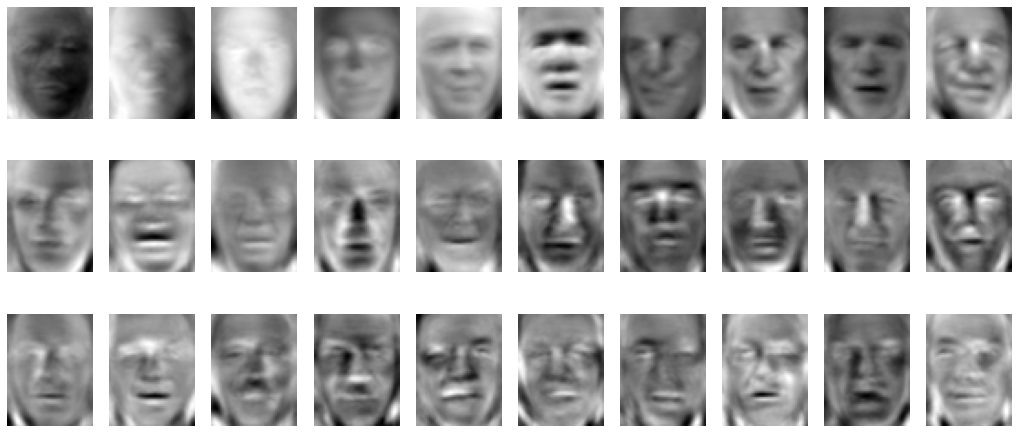

In [9]:
#The components are already sorted by decreasing importance, so we thake the first 30 components.
# They are in the array form, so we have to resize them 
print_images([np.reshape(img, (62,47)) for img in classifier.components_[:30]], ncols=10, colormap='gray')

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

**2.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [10]:
# Your solution here

#As train_test_split takes a random partition, we no longer know which 
# reduction corresponds to which image, so we reduce the whole dataset 
# to be able to compare
reduced = classifier.transform(lfw_people.data)

#Then, we project the train and test sets to new reduced space
X_train_pca = classifier.transform(X_train)
X_test_pca = classifier.transform(X_test)
print(reduced.shape)

(1140, 150)


Do you need to apply the same to the variable y?

# Answer:
No, y contains the classes so we can't apply dimensionality reduction to them. Moreover, we are aplying dimensional reduction to faces, but the classes remain invariant. If an image belongs to class 1, after aplying the transformation it should still belong to class 1.

**2.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces.


<br/>
<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


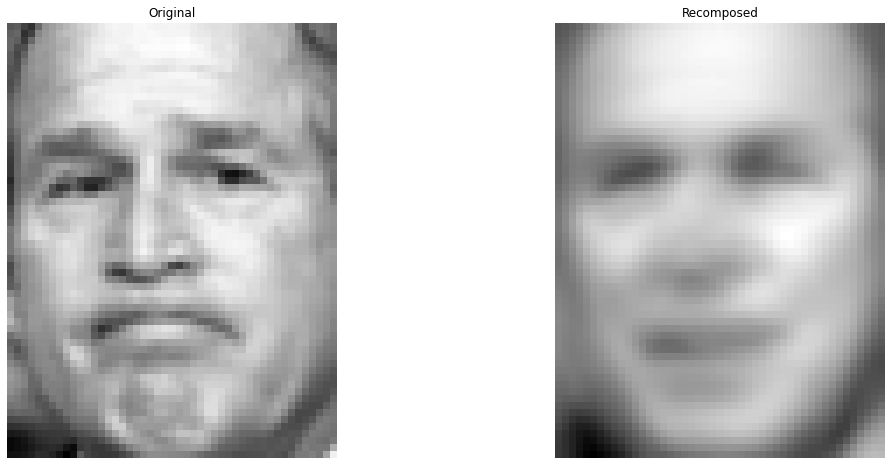

In [11]:
# Your solution here

recomposed = np.asarray([reduced[0][i]*classifier.components_[i] for i in range(10)]) #Multiply the 10 most important components by their computed coefficients
recomposed = recomposed.sum(axis=0) +classifier.mean_ #Sum the values by column (each component is a row)
recomposed = np.reshape(recomposed, (62,47))  #Reshape the row into a rectangle
print_images([lfw_people.images[0], recomposed], ["Original", "Recomposed"], colormap='gray')

#As we are using only 10 components of a total of 150, the mean image 
# still has a very big effect on the recosntructed image.

What is the purpose of the PCA tool?

# Answer:
With PCA we obtain the most important components of a set of images. The purpose is that we can represent each image as a vector in that space, having a much more compact descriptor than the values of each pixel.

### 3. Train a classifier

**3.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [12]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0) #Declare the Adaboost Classifier Object with 50 estimators

start_time = time() #Save the current time
ada.fit(X_train_pca, y_train) #Train the model using the PCA train set
end_time = time() #Save the finishing time

prediction_pca = ada.predict(X_test_pca) #Make a prediction

In [13]:
print("Elapsed time:", end_time - start_time) #Print the time it took to fit the model

Elapsed time: 0.8034391403198242


**3.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [14]:
# Classification and results
from sklearn.metrics import classification_report 
print("PCA score: ", ada.score(X_test_pca, y_test))
print(classification_report(y_test, prediction_pca, target_names=lfw_people.target_names))


PCA score:  0.6374269005847953
                   precision    recall  f1-score   support

     Colin Powell       0.88      0.49      0.63        85
  Donald Rumsfeld       0.39      0.29      0.33        24
    George W Bush       0.63      0.90      0.74       155
Gerhard Schroeder       0.65      0.34      0.45        32
       Tony Blair       0.49      0.39      0.43        46

         accuracy                           0.64       342
        macro avg       0.61      0.48      0.52       342
     weighted avg       0.66      0.64      0.62       342



Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?


# Your explanation here
- accuracy: how close the global classification is to the real result
- precision: percent of the elements classified correctly for a class
- recall: elements classified as a class over the number of elements of the class
- f1-score: harmonic mean between precission and recall (percent of the positive predictions that were correct
- support: number of elements of each class in y_test
- macro average: the average f1-score
- weighted average: the weighted average depending on support


With this info we can see that our dataset is very unbalanced. We have a lot of Bush pictures, only 26 less than all other classes together. We will problably get  good results on Bush, but not that good on the others.


**3.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [15]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
#Same as above but using the non PCA set
start_time = time()
ada.fit(X_train, y_train)
end_time = time()
prediction = ada.predict(X_test)

In [16]:
print("Elapsed time:\t", end_time - start_time)
print("Non PCA score:\t", ada.score(X_test, y_test))
print(classification_report(y_test, prediction, target_names=lfw_people.target_names))

Elapsed time:	 9.408557891845703
Non PCA score:	 0.5935672514619883
                   precision    recall  f1-score   support

     Colin Powell       0.71      0.42      0.53        85
  Donald Rumsfeld       0.41      0.29      0.34        24
    George W Bush       0.58      0.86      0.69       155
Gerhard Schroeder       0.87      0.41      0.55        32
       Tony Blair       0.48      0.30      0.37        46

         accuracy                           0.59       342
        macro avg       0.61      0.46      0.50       342
     weighted avg       0.61      0.59      0.57       342



**Questions**

- Does computing time change using PCA? How?
- Which of both (with and without PCA) does give better results?
- How does the result change if we change the number of components in PCA?
- How does the result change if we change the number of estimators in the Adaboost?

# Answer
- Yes, using PCA is a lot faster (0.6s vs 8.7s)
- The results seem to be better with PCA, usually a with a difference in score of 0.04.
- Scores tend to increase when we increase the number of components, but we should be wary of not overfitting the model with the training set, wich seems to happen if we increase the value to much.
- Scores decrease when we decrease the number of estimators and seem to increase if we increase them up to 150. As above, we should be coutious of not overfitting the model with the training data when increasing a lot the number of estimators.

**3.5 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

In [17]:
# Your solution here

### 4. Recognize a new face example using the learned model

**4.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [18]:
#Non PCA Prediction
n_img = 16
titles = ["predicted %s\n true %s" % (lfw_people.target_names[prediction[i]], lfw_people.target_names[y_test[i]]) for i in range(n_img)]
img = [np.reshape(img, (62,47)) for img in X_test[:n_img]]
print_images(img, titles, ncols=4, colormap='gray')

In [19]:
#PCA Prediction
print(X_test.shape)
titles = ["predicted: %s\n true: %s" % (lfw_people.target_names[prediction_pca[i]], lfw_people.target_names[y_test[i]]) for i in range(n_img)]
img = [np.reshape(img, (62,47)) for img in X_test[:n_img]]
print_images(img, titles, ncols=4, colormap='gray')

(342, 2914)


Which model makes the predictions betters? Try different parameters.

# Your solution here
As we have seen in prevoius exercices, the PCA predictions give better scores. In this test we can also see that PCA gives more accurate predictions. As we predicted in exercise 3.2, the set is a unbalanced and there are a lot of Bush images, so most of the predictions of non PCA were biased towards Bush. However, in the PCA prediction we can see that there are far better predictions in non Bush images, wich confirms the better scores.